# Modelo #3 Red Convolucional Multivariada

In [161]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
import pickle

from numpy import hstack
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.metrics import r2_score
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dropout
from keras.layers import Dense
from sklearn import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [114]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

## Cargar Datos

In [115]:
df = pd.read_csv("HistoricalQuotes.csv")
df.head()

,date,close,volume,open,high,low
0,2019/03/14,19.95,73578.0,20.14,20.180,19.90
1,2019/03/13,20.10,103553.0,20.30,20.330,19.99
2,2019/03/12,20.37,101823.0,20.79,20.905,20.34
3,2019/03/11,20.89,74490.0,21.03,21.100,20.71
4,2019/03/08,20.99,137966.0,20.41,21.100,20.41


In [116]:
# Ordeno el dataframe por fecha
df = df.sort_values(by=['date'],ascending=True)
df = df.reset_index(drop=True)
df.head()

,date,close,volume,open,high,low
0,2009/03/16,1.51,66174.0,1.50,1.53,1.500
1,2009/03/17,1.51,35448.0,1.68,1.68,1.490
2,2009/03/18,1.49,26360.0,1.50,1.53,1.490
3,2009/03/19,1.41,189240.0,1.43,1.48,1.365
4,2009/03/20,1.45,76175.0,1.41,1.47,1.400


In [117]:
precio_cierre = df["close"].values.reshape(-1,1)
precio_cierre

array([[ 1.51],
       [ 1.51],
       [ 1.49],
       ...,
       [20.37],
       [20.1 ],
       [19.95]])

## Multivariate CNN

Aquí involucramos las otras dimensiones de nuestro dataset, por lo tanto va a existir más de una observación por cada período de tiempo

Una Red Convolucional necesita suficiente contexto temporal para aprender a mapear dad una entrada cual es el siguiente valor, y así como la CNN puede separar colores como rojo, verde y azul de una imagen, también lo puede hacer con series paralelas y predecir un solo valor 

In [118]:
# Número de días a predecir
time_to_predict = 60

### Preprocesamiento

In [119]:
# escalamiento de todo mi data set

columnas_a_escalar = list(df.columns[1:len(df.columns)])

scaler = MinMaxScaler(feature_range = (0, 1))

sc = MinMaxScaler(feature_range = (0, 1))
machete = sc.fit_transform(df["close"].values.reshape(-1,1))

df[columnas_a_escalar] = scaler.fit_transform(df[columnas_a_escalar])
# dataset escalado
df.head()

,date,close,volume,open,high,low
0,2009/03/16,0.003634,0.031916,0.004345,0.002171,0.004914
1,2009/03/17,0.003634,0.017097,0.010862,0.007598,0.004550
2,2009/03/18,0.002907,0.012713,0.004345,0.002171,0.004550
3,2009/03/19,0.000000,0.091271,0.001810,0.000362,0.000000
4,2009/03/20,0.001453,0.036739,0.001086,0.000000,0.001274


### train/test

In [120]:
# todos los datos excepto los que voy a predecir 
data_train = df.iloc[0:-time_to_predict]

# datos que voy a predecir
data_test = df[-time_to_predict:len(df)]

### Construcción estructura multivariada

In [121]:
def partir_en_secuencias(secuencias, retardos):
    """
    Función para partir mi serie multivariada 
    """
    X, y = list(), list()
    
    for i in range(len(secuencias)):
        
        # encuentra el fin del patrón i        
        fin_ix = i + retardos
        
        # revisamos si nos pasamos del fin del dataset
        if fin_ix >= len(secuencias):
            break
        
        # va de i hasta el fin del patron i y de esos que coge
        # deja la última columna por fuera
        seq_x = secuencias[i:fin_ix, :-1]
        
        # me paro en la última posición de mi patrón de retardos y
        # cojo el último elemento, que en este caso sería mi "y"
        seq_y = secuencias[fin_ix, -1]
              
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X), array(y)

In [122]:
def preparar_datos_multivariada(datos):
    
    # todas menos la fecha
    columnas_de_interes = list(datos.columns[1:len(datos.columns)])
    
    # cada columna del dataframe la paso a lista
    close_price = datos["close"].values
    volume_val = datos["volume"].values
    open_price = datos["open"].values
    high_price = datos["high"].values
    low_price = datos["low"].values
    
    # cada lista, la vuelvo columna 
    close_price = close_price.reshape((len(close_price), 1))
    volume_val =  volume_val.reshape((len(volume_val), 1))
    open_price = open_price.reshape((len(open_price), 1))
    high_price = high_price.reshape((len(high_price), 1))
    low_price = low_price.reshape((len(low_price), 1))
   
    # retorno las columnas pegadas horizontalmente, y en la última posición va ir nuestra "y" 
    # que en este caso es el precio de cierre
    return hstack((close_price,volume_val,open_price,high_price,low_price,close_price))


In [123]:
## mini pruebita de estructura de los datos

a = np.array([1,2,3,4,5,6,7])
b = np.array([i*2 for i in a])
c = np.array([i*2 for i in b])

a = a.reshape((len(a), 1))
b = b.reshape((len(b), 1))
c = c.reshape((len(c), 1))
d = a
# horizontally stack columns
dataset = hstack((a,b,c,d))
print(dataset)

w,q = partir_en_secuencias(dataset,2)

print(w[0],q[0])
print(w[1],q[1])

[[ 1  2  4  1]
 [ 2  4  8  2]
 [ 3  6 12  3]
 [ 4  8 16  4]
 [ 5 10 20  5]
 [ 6 12 24  6]
 [ 7 14 28  7]]
[[1 2 4]
 [2 4 8]] 3
[[ 2  4  8]
 [ 3  6 12]] 4


In [124]:
dataset = preparar_datos_multivariada(data_train)

retardos = 20

In [125]:
X, y = partir_en_secuencias(dataset, retardos)

# el último valor de t+1 es igual al de y en el precio t
print(X[1][-1:][0][0],y[0])

0.012718023255813955 0.012718023255813955


In [126]:
# número de caracterisitcas o predictores de mi data set
n_features = X.shape[2]
n_features

5

### Construcción de dataset para predecir

In [127]:
inputs = df.iloc[(len(df) - len(data_test) - retardos):len(df)]
len(inputs)

80

In [128]:
data_test = preparar_datos_multivariada(inputs)
print(data_test[0:10])

[[0.54760174 0.05424437 0.53801593 0.54486252 0.5366697  0.54760174]
 [0.55232558 0.04484384 0.54344678 0.55137482 0.54431301 0.55232558]
 [0.53524709 0.06048389 0.54923968 0.54848046 0.53739763 0.53524709]
 [0.5181686  0.08252697 0.52896452 0.53726483 0.51919927 0.5181686 ]
 [0.54505814 0.05870517 0.52099928 0.54739508 0.52429481 0.54505814]
 [0.53561047 0.01559568 0.54344678 0.5397974  0.53630573 0.53561047]
 [0.54324128 0.06896756 0.54127444 0.54305355 0.53484986 0.54324128]
 [0.53815407 0.04044574 0.5416365  0.53798842 0.5366697  0.53815407]
 [0.54832849 0.0712527  0.53801593 0.54377713 0.5344859  0.54832849]
 [0.55886628 0.08396278 0.54634323 0.55716353 0.54504095 0.55886628]]


In [129]:
data_test,_ = partir_en_secuencias(data_test,retardos)

x_input = array(data_test)

x_input = x_input.reshape((len(x_input), retardos, n_features))

## Construcción  arquitectura CNN multivariada

### Tuning de Retardos

Suposición de Hiperparametros:

    * Capas ocultas      1
    * Neuronas por capa  128
    * lr                 0.001
    * epochs             100
    * batch              32

In [102]:
def tuning_retardos(nro_retardos):
    
    resultado_retardos = []
    
    for j in range(len(nro_retardos)):
        
        
        # todos los datos excepto los que voy a predecir 
        data_train = df.iloc[0:-time_to_predict]

        # datos que voy a predecir
        data_test = df[-time_to_predict:len(df)]       
        
        dataset = preparar_datos_multivariada(data_train)

        retardos = nro_retardos[j]

        X, y = partir_en_secuencias(dataset, retardos)

        # número de caracterisitcas o predictores de mi data set
        n_features = X.shape[2]

        
        ### Construcción de dataset para predecir
        inputs = df.iloc[(len(df) - len(data_test) - retardos):len(df)]  

        data_test = preparar_datos_multivariada(inputs)    

        data_test,_ = partir_en_secuencias(data_test,retardos)

        x_input = array(data_test)

        x_input = x_input.reshape((len(x_input), retardos, n_features))
        
        
        ################################################################################################################

        
        cnn_multivariate = Sequential()
        cnn_multivariate.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(retardos, n_features)))
        cnn_multivariate.add(MaxPooling1D(pool_size=2))
   
        cnn_multivariate.add(Flatten())

        cnn_multivariate.add(Dense(100, activation='relu'))
        cnn_multivariate.add(Dense(1))

        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
        # mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

        cnn_multivariate.compile(optimizer=adam, loss='mse')

        # entrenamiento
        history = cnn_multivariate.fit(X, y, epochs =100,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)

        
        # predigo los datos de entrada de prueba
        predicted_stock_price = cnn_multivariate.predict(x_input)

        # aplico la transformación inversa para dejar los datos en la escala inicial
        #predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        # precios reales
        real_stock_price = precio_cierre[-(time_to_predict):]
        
        
        resultado_retardos.append([predicted_stock_price,
                                   real_stock_price,
                                   [metrics.mean_absolute_error(real_stock_price, predicted_stock_price),
                                    metrics.mean_squared_error(real_stock_price, predicted_stock_price),
                                    np.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price))],
                                    len(cnn_multivariate.history.history['loss']),
                                    r2_score(real_stock_price,predicted_stock_price)                                    
                                   ])       
        
        
    return resultado_retardos

nro_retardos = [20,40,60,100]

resultado_tuning_retardos = tuning_retardos(nro_retardos)
         

Train on 1949 samples, validate on 488 samples
Epoch 1/100
1949/1949 [==============================] - 1s 521us/step - loss: 0.0093 - val_loss: 0.0011
Epoch 2/100
1949/1949 [==============================] - 0s 124us/step - loss: 8.7821e-04 - val_loss: 0.0015
Epoch 3/100
1949/1949 [==============================] - 0s 127us/step - loss: 7.7823e-04 - val_loss: 0.0020
Epoch 4/100
1949/1949 [==============================] - 0s 128us/step - loss: 6.0406e-04 - val_loss: 0.0011
Epoch 5/100
1949/1949 [==============================] - 0s 126us/step - loss: 5.5841e-04 - val_loss: 9.0722e-04
Epoch 6/100
1949/1949 [==============================] - 0s 126us/step - loss: 5.7154e-04 - val_loss: 6.0040e-04
Epoch 7/100
1949/1949 [==============================] - 0s 127us/step - loss: 4.4615e-04 - val_loss: 8.1902e-04
Epoch 8/100
1949/1949 [==============================] - 0s 129us/step - loss: 4.4807e-04 - val_loss: 6.6369e-04
Epoch 9/100
1949/1949 [==============================] - 0s 128us/ste

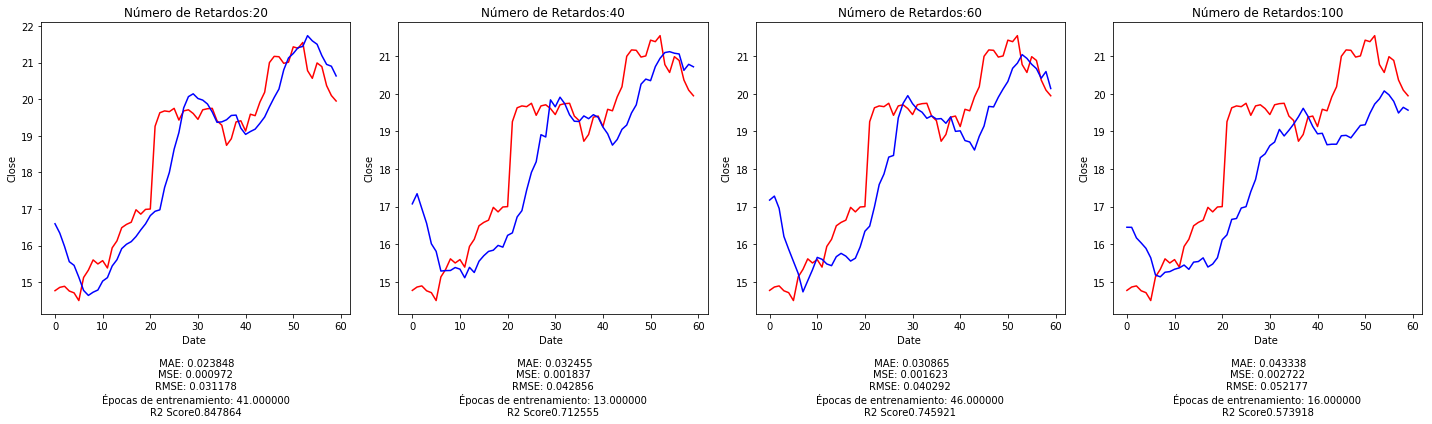

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,6))

count = 0
for ax in axes:    
        
    titulo = str("Número de retardos:"+str(nro_retardos[count])) 
        
    ax.plot(sc.inverse_transform(resultado_tuning_retardos[count][1]),color = 'red',label = 'Real S&P Stock Price')
    ax.plot(sc.inverse_transform(resultado_tuning_retardos[count][0]),color = 'blue',label = 'Predicted S&P Stock Price')
    
    ax.set_xlabel('Date \n'+
                  str('\n MAE: ' + '{:f}'.format(resultado_tuning_retardos[count][2][0]))+'\n'+
                  str('MSE: ' + '{:f}'.format(resultado_tuning_retardos[count][2][1]))+'\n'+
                  str('RMSE: ' + '{:f}'.format(resultado_tuning_retardos[count][2][2]))+'\n'+
                  str('Épocas de entrenamiento: ' + '{:f}'.format(resultado_tuning_retardos[count][3]))+'\n'+
                  str('R2 Score' + '{:f}'.format(resultado_tuning_retardos[count][4])) 
                 )
    ax.set_ylabel('Close')
    ax.set_title(str('Número de Retardos:'+str(nro_retardos[count])))

    fig    
    plt.tight_layout()
    
    count+=1



Resultado tunning retardos: **20, Mejor R2 y menor errores en las diferentes métricas**

### Tuning de Capas ocultas

In [130]:
def grid_layers(layers):
    
    resultado_capas = []
    
    for i in range(len(layers)):   

        cnn_multivariate = Sequential()
        cnn_multivariate.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(retardos, n_features)))
        cnn_multivariate.add(MaxPooling1D(pool_size=2))
        #cnn_univariate.add(Flatten())
        
        for j in range(layers[i]-1):
            
            cnn_multivariate.add(Conv1D(filters=int(128/layers[i]), kernel_size=2, activation='relu'))
            

        cnn_multivariate.add(MaxPooling1D(pool_size=2))
        cnn_multivariate.add(Flatten())

        cnn_multivariate.add(Dense(100, activation='relu'))
        cnn_multivariate.add(Dense(1))

        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
        # mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

        cnn_multivariate.compile(optimizer=adam, loss='mse')

        # entrenamiento
        history = cnn_multivariate.fit(X, y, epochs =100,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)

        
        # predigo los datos de entrada de prueba
        predicted_stock_price = cnn_multivariate.predict(x_input)

        # aplico la transformación inversa para dejar los datos en la escala inicial
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        # precios reales
        real_stock_price = list(df["close"].iloc[-len(data_test):])
        
        
        resultado_capas.append([predicted_stock_price,
                               real_stock_price,
                               [metrics.mean_absolute_error(real_stock_price, predicted_stock_price),
                                metrics.mean_squared_error(real_stock_price, predicted_stock_price),
                                np.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price))],
                                len(cnn_multivariate.history.history['loss']),
                                r2_score(real_stock_price,predicted_stock_price)    
                               ])
    
    return resultado_capas


layers = [0,2,4,8]
resultado_arquitectura_capas = grid_layers(layers)


Train on 1949 samples, validate on 488 samples
Epoch 1/100
1949/1949 [==============================] - 2s 1ms/step - loss: 0.0199 - val_loss: 0.0011
Epoch 2/100
1949/1949 [==============================] - 0s 148us/step - loss: 8.4579e-04 - val_loss: 0.0014
Epoch 3/100
1949/1949 [==============================] - 0s 153us/step - loss: 7.7875e-04 - val_loss: 0.0010
Epoch 4/100
1949/1949 [==============================] - 0s 153us/step - loss: 7.5844e-04 - val_loss: 0.0013
Epoch 5/100
1949/1949 [==============================] - 0s 154us/step - loss: 6.9140e-04 - val_loss: 0.0013
Epoch 6/100
1949/1949 [==============================] - 0s 148us/step - loss: 7.3130e-04 - val_loss: 0.0011
Epoch 7/100
1949/1949 [==============================] - 0s 151us/step - loss: 6.5338e-04 - val_loss: 0.0011
Epoch 8/100
1949/1949 [==============================] - 0s 161us/step - loss: 6.6931e-04 - val_loss: 9.0604e-04
Epoch 9/100
1949/1949 [==============================] - 0s 164us/step - loss: 5.95

Epoch 66/100
1949/1949 [==============================] - 0s 147us/step - loss: 4.1962e-04 - val_loss: 8.2710e-04
Epoch 67/100
1949/1949 [==============================] - 0s 153us/step - loss: 4.1954e-04 - val_loss: 8.2835e-04

Epoch 00067: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 68/100
1949/1949 [==============================] - 0s 142us/step - loss: 4.1959e-04 - val_loss: 8.2775e-04
Epoch 69/100
1949/1949 [==============================] - 0s 143us/step - loss: 4.1962e-04 - val_loss: 8.2784e-04
Epoch 00069: early stopping
Train on 1949 samples, validate on 488 samples
Epoch 1/100
1949/1949 [==============================] - 2s 1ms/step - loss: 0.0207 - val_loss: 0.0015
Epoch 2/100
1949/1949 [==============================] - 0s 195us/step - loss: 8.6737e-04 - val_loss: 0.0011
Epoch 3/100
1949/1949 [==============================] - 0s 190us/step - loss: 7.9821e-04 - val_loss: 0.0026
Epoch 4/100
1949/1949 [==============================] - 0s 189us/s

1949/1949 [==============================] - 1s 278us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 10/100
1949/1949 [==============================] - 1s 259us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 11/100
1949/1949 [==============================] - 1s 257us/step - loss: 0.0010 - val_loss: 0.0020
Epoch 12/100
1949/1949 [==============================] - 0s 256us/step - loss: 9.8253e-04 - val_loss: 0.0015
Epoch 13/100
1949/1949 [==============================] - 0s 252us/step - loss: 9.7224e-04 - val_loss: 0.0026
Epoch 14/100
1949/1949 [==============================] - 0s 251us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 15/100
1949/1949 [==============================] - 0s 251us/step - loss: 9.5298e-04 - val_loss: 0.0014

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16/100
1949/1949 [==============================] - 0s 248us/step - loss: 9.5564e-04 - val_loss: 0.0014
Epoch 17/100
1949/1949 [==============================] - 0s 245us/s

Epoch 75/100
1949/1949 [==============================] - 0s 240us/step - loss: 8.5607e-04 - val_loss: 0.0014
Epoch 76/100
1949/1949 [==============================] - 0s 245us/step - loss: 8.5605e-04 - val_loss: 0.0014
Epoch 77/100
1949/1949 [==============================] - 0s 241us/step - loss: 8.5607e-04 - val_loss: 0.0014

Epoch 00077: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 78/100
1949/1949 [==============================] - 0s 241us/step - loss: 8.5604e-04 - val_loss: 0.0014
Epoch 79/100
1949/1949 [==============================] - 0s 246us/step - loss: 8.5603e-04 - val_loss: 0.0014
Epoch 80/100
1949/1949 [==============================] - 0s 240us/step - loss: 8.5602e-04 - val_loss: 0.0014
Epoch 81/100
1949/1949 [==============================] - 0s 247us/step - loss: 8.5604e-04 - val_loss: 0.0014
Epoch 82/100
1949/1949 [==============================] - 0s 239us/step - loss: 8.5603e-04 - val_loss: 0.0014

Epoch 00082: ReduceLROnPlateau reducin

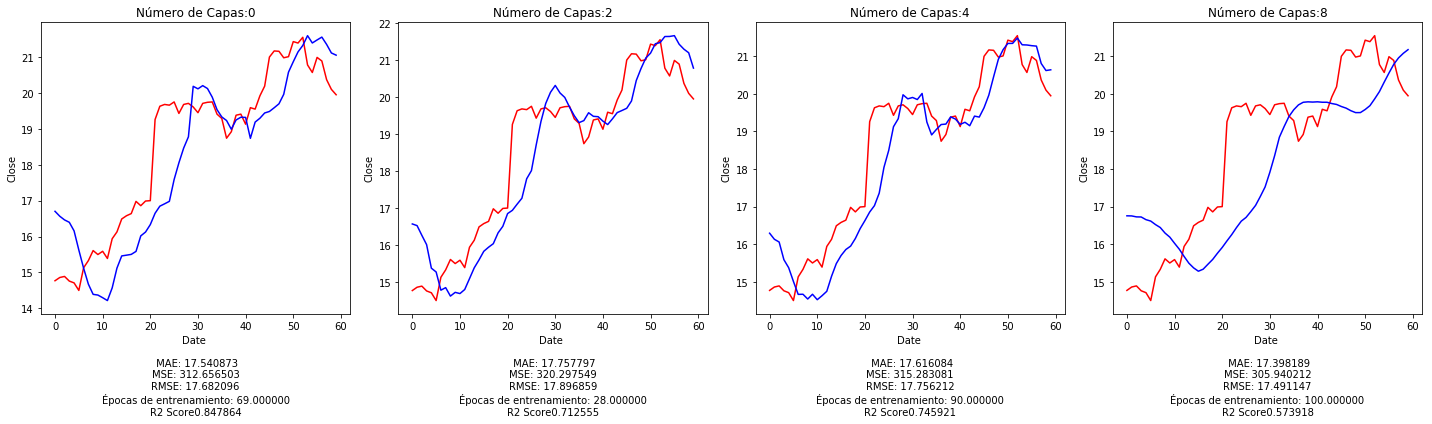

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,6))

count = 0
for ax in axes:    
        
    titulo = str("Número de capas:"+str(layers[count])) 
    
    #print("MAE",resultado_arquitectura_capas[count][2][0])
    #print("MSE",resultado_arquitectura_capas[count][2][1])
    #print("RMSE",resultado_arquitectura_capas[count][2][2])
    #print("Epocas necesarias:",resultado_arquitectura_capas[count][3])
        
    ax.plot(sc.inverse_transform(np.array(resultado_arquitectura_capas[count][1]).reshape(-1,1)),color = 'red',label = 'Real S&P Stock Price')
    ax.plot(resultado_arquitectura_capas[count][0],color = 'blue',label = 'Predicted S&P Stock Price')
    
    ax.set_xlabel('Date \n'+
                  str('\n MAE: ' + '{:f}'.format(resultado_arquitectura_capas[count][2][0]))+'\n'+
                  str('MSE: ' + '{:f}'.format(resultado_arquitectura_capas[count][2][1]))+'\n'+
                  str('RMSE: ' + '{:f}'.format(resultado_arquitectura_capas[count][2][2]))+'\n'+
                  str('Épocas de entrenamiento: ' + '{:f}'.format(resultado_arquitectura_capas[count][3]))+'\n'+
                  str('R2 Score' + '{:f}'.format(resultado_tuning_retardos[count][4])) 
                 )
    ax.set_ylabel('Close')
    ax.set_title(str('Número de Capas:'+str(layers[count])))

    fig    
    plt.tight_layout()
    
    count+=1


Resultado Tuning capas ocultas: **0  capas**, mejor R2 y menor error

### Tunning neuronas 

In [136]:
def grid_neurons(neuronas):
    
    resultado_neuronas = []
    
    for i in range(len(neuronas)):          

        cnn_multivariate = Sequential()
        cnn_multivariate.add(Conv1D(filters=neuronas[i], kernel_size=2, activation='relu', input_shape=(retardos, n_features)))
        cnn_multivariate.add(MaxPooling1D(pool_size=2))
   
        cnn_multivariate.add(Flatten())

        cnn_multivariate.add(Dense(100, activation='relu'))
        cnn_multivariate.add(Dense(1))

        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
        # mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

        cnn_multivariate.compile(optimizer=adam, loss='mse')

        # entrenamiento
        history = cnn_multivariate.fit(X, y, epochs =100,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)

        
        # predigo los datos de entrada de prueba
        predicted_stock_price = cnn_multivariate.predict(x_input)

        # aplico la transformación inversa para dejar los datos en la escala inicial
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        # precios reales
        real_stock_price = list(df["close"].iloc[-len(data_test):])
        
        
        resultado_neuronas.append([predicted_stock_price,
                               real_stock_price,
                               [metrics.mean_absolute_error(real_stock_price, predicted_stock_price),
                                metrics.mean_squared_error(real_stock_price, predicted_stock_price),
                                np.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price))],
                                len(cnn_multivariate.history.history['loss']),
                                r2_score(real_stock_price,predicted_stock_price) 
                               ])
    return resultado_neuronas

neuronas = [32,64,128,256]
resultado_arquitectura_neuronas = grid_neurons(neuronas)


Train on 1949 samples, validate on 488 samples
Epoch 1/100
1949/1949 [==============================] - 2s 1ms/step - loss: 0.0145 - val_loss: 0.0013
Epoch 2/100
1949/1949 [==============================] - 0s 112us/step - loss: 9.6333e-04 - val_loss: 0.0014
Epoch 3/100
1949/1949 [==============================] - 0s 110us/step - loss: 9.0734e-04 - val_loss: 0.0024
Epoch 4/100
1949/1949 [==============================] - 0s 111us/step - loss: 8.1976e-04 - val_loss: 0.0011
Epoch 5/100
1949/1949 [==============================] - ETA: 0s - loss: 7.6889e-0 - 0s 129us/step - loss: 7.6508e-04 - val_loss: 0.0010
Epoch 6/100
1949/1949 [==============================] - 0s 128us/step - loss: 7.6676e-04 - val_loss: 9.5482e-04
Epoch 7/100
1949/1949 [==============================] - 0s 120us/step - loss: 6.3011e-04 - val_loss: 0.0012
Epoch 8/100
1949/1949 [==============================] - 0s 116us/step - loss: 5.9994e-04 - val_loss: 0.0011
Epoch 9/100
1949/1949 [==============================] 

Epoch 9/100
1949/1949 [==============================] - 0s 116us/step - loss: 4.6533e-04 - val_loss: 0.0022
Epoch 10/100
1949/1949 [==============================] - 0s 115us/step - loss: 4.7456e-04 - val_loss: 7.7234e-04

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/100
1949/1949 [==============================] - 0s 131us/step - loss: 3.5333e-04 - val_loss: 7.0078e-04
Epoch 12/100
1949/1949 [==============================] - 0s 128us/step - loss: 3.5563e-04 - val_loss: 6.7339e-04
Epoch 13/100
1949/1949 [==============================] - 0s 126us/step - loss: 3.8381e-04 - val_loss: 6.3451e-04
Epoch 14/100
1949/1949 [==============================] - 0s 125us/step - loss: 3.4345e-04 - val_loss: 6.6365e-04
Epoch 15/100
1949/1949 [==============================] - 0s 125us/step - loss: 3.5288e-04 - val_loss: 0.0010
Epoch 16/100
1949/1949 [==============================] - 0s 123us/step - loss: 3.6703e-04 - val_loss: 7.0247e-04

Epoch 00016: Re

1949/1949 [==============================] - 0s 246us/step - loss: 2.5934e-04 - val_loss: 4.7368e-04

Epoch 00026: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 27/100
1949/1949 [==============================] - 1s 276us/step - loss: 2.5601e-04 - val_loss: 5.1312e-04
Epoch 28/100
1949/1949 [==============================] - 1s 259us/step - loss: 2.5441e-04 - val_loss: 4.9149e-04
Epoch 29/100
1949/1949 [==============================] - 0s 247us/step - loss: 2.5497e-04 - val_loss: 4.8373e-04
Epoch 30/100
1949/1949 [==============================] - 0s 239us/step - loss: 2.5638e-04 - val_loss: 4.9566e-04
Epoch 31/100
1949/1949 [==============================] - 0s 231us/step - loss: 2.4902e-04 - val_loss: 5.2865e-04

Epoch 00031: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 32/100
1949/1949 [==============================] - 0s 223us/step - loss: 2.4353e-04 - val_loss: 4.7431e-04
Epoch 33/100
1949/1949 [==============================

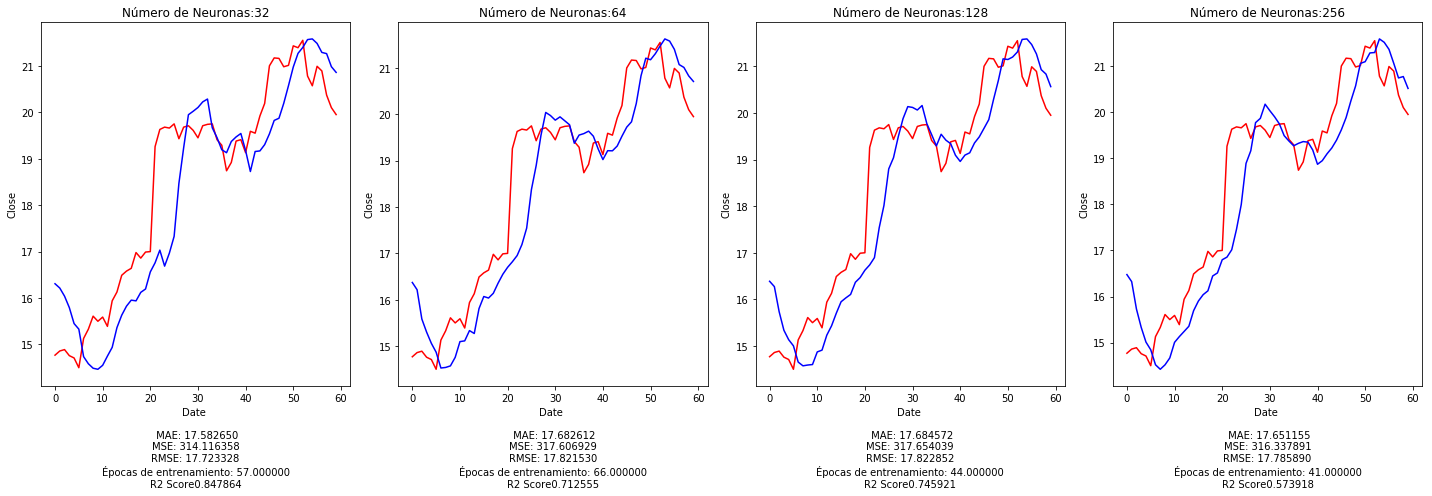

In [137]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,7))

count = 0
for ax in axes:  

    titulo = str("Número de Neuronas:"+str(neuronas[count])) 

    ax.plot(sc.inverse_transform(np.array(resultado_arquitectura_neuronas[count][1]).reshape(-1,1)),color = 'red',label = 'Real S&P Stock Price')
    ax.plot(resultado_arquitectura_neuronas[count][0],color = 'blue',label = 'Predicted S&P Stock Price')

    ax.set_xlabel('Date \n'+
                  str('\n MAE: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][2][0]))+'\n'+
                  str('MSE: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][2][1]))+'\n'+
                  str('RMSE: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][2][2]))+'\n'+
                  str('Épocas de entrenamiento: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][3]))+'\n'+
                  str('R2 Score' + '{:f}'.format(resultado_tuning_retardos[count][4])) 
                 )
    ax.set_ylabel('Close')
    ax.set_title(str('Número de Neuronas:'+str(neuronas[count])))

    fig    
    plt.tight_layout()

    count+=1


Resultado tuning neuronas: **32 filtros** en capa convolucional multiv

## Modelo final Convolucional multivariada

Parámetros de Arquitectura:
    
    * 0 capas ocultas
    * 32 filtros por capa conv
    * 20 retardos
    * 0.001 lr
    * 100 epochs

In [155]:
cnn_multivariate = Sequential()
cnn_multivariate.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(retardos, n_features)))
cnn_multivariate.add(MaxPooling1D(pool_size=2))

cnn_multivariate.add(Flatten())

cnn_multivariate.add(Dense(100, activation='relu'))
cnn_multivariate.add(Dense(1))

adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=7, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=7, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

cnn_multivariate.compile(optimizer=adam, loss='mse')

# entrenamiento
history = cnn_multivariate.fit(X, y, epochs =100,callbacks=[es, rlr], batch_size = 16,validation_split=0.2)


# predigo los datos de entrada de prueba
predicted_stock_price = cnn_multivariate.predict(x_input)

# aplico la transformación inversa para dejar los datos en la escala inicial
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# precios reales
real_stock_price = list(df["close"].iloc[-len(data_test):])

Train on 1949 samples, validate on 488 samples
Epoch 1/100
1949/1949 [==============================] - 3s 1ms/step - loss: 0.0614 - val_loss: 0.0023
Epoch 2/100
1949/1949 [==============================] - 0s 227us/step - loss: 9.3835e-04 - val_loss: 0.0027
Epoch 3/100
1949/1949 [==============================] - 0s 215us/step - loss: 8.5520e-04 - val_loss: 0.0028
Epoch 4/100
1949/1949 [==============================] - 0s 203us/step - loss: 7.8960e-04 - val_loss: 0.0028
Epoch 5/100
1949/1949 [==============================] - 0s 217us/step - loss: 5.9058e-04 - val_loss: 0.0016
Epoch 6/100
1949/1949 [==============================] - 0s 213us/step - loss: 6.5933e-04 - val_loss: 8.0113e-04
Epoch 7/100
1949/1949 [==============================] - 0s 217us/step - loss: 4.4817e-04 - val_loss: 6.2840e-04
Epoch 8/100
1949/1949 [==============================] - 0s 212us/step - loss: 5.3301e-04 - val_loss: 6.5457e-04
Epoch 9/100
1949/1949 [==============================] - 0s 203us/step - lo

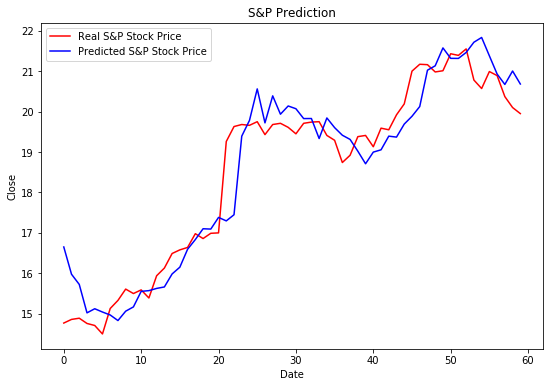

In [156]:
figure(figsize=(9,6))
plt.plot(sc.inverse_transform(np.array(real_stock_price).reshape(-1,1)), color = 'red', label = 'Real S&P Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted S&P Stock Price')
plt.title('S&P Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [157]:
print("R2 score:",r2_score(sc.inverse_transform(np.array(real_stock_price).reshape(-1,1)),predicted_stock_price))

R2 score: 0.9043049946382454


In [158]:
#guardo el modelo en disco
cnn_multivariate.save("cnn_multivariate.h5") 

In [162]:
## escribo X_test para modelo 3 para luego leerla
with open('X_test_3.data', 'wb') as filehandle:  
    pickle.dump(x_input, filehandle)